In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt

# Load tudatpy modules
from tudatpy.kernel.interface import spice
from tudatpy.kernel import numerical_simulation
from tudatpy.kernel.numerical_simulation import environment_setup
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.astro import element_conversion
from tudatpy.kernel import constants
from tudatpy.util import result2array

In [2]:
# Load spice kernels
spice.load_standard_kernels()

## Select Modes

In [3]:
#Case list:
#0 = no propulsion
#1 = Simple propulsion
#2 = Horizon only
#3 = elevation angle
Case_id = 3


#location list:
#1 = Mount everest top
#2 = Delft
Location_id = 2

#Laser list:
#0 = No propulsion
#1 = CO2 laser
#2 = COIL of the YAL-1
#99 =  brute force output test
Laser_type_id = 2
if Case_id ==0:
    Laser_type_id = 0


#Propellant list:
#1 = PMMA
#2 = Pyroxylin
#3 = Aluminium
#4 = Pure photon impact
Propellant_id = 1

In [4]:
#Input settings:
#time
maxdays = 1500
simulation_start_epoch = 0.0
simulation_end_epoch = maxdays*constants.JULIAN_DAY 
T_step = 50 #seconds

#Satellite
Satellite_mass = 3
Drag_area = 0.05
Cd_sat = 1.2
Radiation_area = 0.05
Cd_radiation = 1.2

#orbit
Altitude = 450000
ecc = 0
incl = np.deg2rad(85.3)
arg_of_peri=np.deg2rad(235.7)
long_of_asc_node=np.deg2rad(23.4)
true_anom=np.deg2rad(139.87)

#(ablative) surface
Surface_area = 30
Reflectivity = 0.9 #https://anomet.com/reflective-aluminum#:~:text=The%20most%20reflective%20metals%20in,photometric%20qualities%20to%20control%20light.
r_hotspot = 0.05
Surface_angle = 0

#laser
Extinction = 0.005 #0.00000001 #km-1
Tube_diameter = 18 #cm
Tube_length = 1000 #cm
Brute_force_power = 0.00007#1e-15
Max_pulse_duration = 0.01
Time_for_Pulse_sequence = 10
if Laser_type_id == 2:
    r_lsr = 4.5
if Laser_type_id == 1:
    r_lsr = 34
if Laser_type_id == 0:
    r_lsr = 10
COIL_power = 20000.

#Thrust
Thrustm = 0.000007
T_i = 10000
if Case_id == 2:
    Lower_bound_limit = np.deg2rad(0)
    Upper_bound_limit = np.deg2rad(180)
elif Case_id == 3:
    Lower_bound_limit = np.deg2rad(0)
    Upper_bound_limit = np.deg2rad(180)
else:
    Lower_bound_limit = np.deg2rad(0)
    Upper_bound_limit = np.deg2rad(180)


#environment #Overall payload ratio of a combined laser and chemical propulsion system for GEO launch
beta_r = 1.35e-4 #A New Zenith Tropospheric Delay Grid Product for Real-Time PPP Applications over China
epsilon = 1.25e-5 #Atmospheric absorption coeMcient from: Overall payload ratio of a combined laser and chemical propulsion system for GEO launch

## Constants

In [5]:
r_earth = 6371008.366666666
k = 1.380649*10**(-23) #bolzmann
UtoKg = 1.660538782*10**(-27)
g_0 = 9.80665

## Create empty arrays for variable storage

In [6]:
Laser_velocity_angle_array = []
timeforthis = []
binary_indicator_velocity_angle = []
SMAcheck = []
Rangecheck = []
echeck = []
elecheck = []

## Create Ground Station

In [7]:
if Location_id == 1:
    Laser_system_altitude = 8849
    Laser_system_latitude = np.deg2rad(27.9881)
    Laser_system_longitude = np.deg2rad(86.9250)
elif Location_id == 2:
    Laser_system_altitude = 0
    Laser_system_latitude = np.deg2rad(52.00667)
    Laser_system_longitude = np.deg2rad(4.35556)


## Propulsion function

In [8]:
class thrust_model:
    
    def __init__(self, Laser_type_id, Surface_area, propagated_body,Location_id,Propellant_id):
        self.laserstation = laser(Laser_type_id)
        self.locationstation = location(Location_id)
        self.propellant = Propellant(Propellant_id)
        self.Sat= Sat(propagated_body)
        self.Location_id = Location_id     
        self.Surface_area = Surface_area
        self.Isp = self.propellant.get_Isp()                           # Specific impulse [s]
        self.propagated_body = propagated_body   # Body that is being propagated (tudatpy.numerical_simulation.environment.Body)
        self.Propellant_id = Propellant_id
        
    def get_thrust_magnitude(self, time):
        try:
            Sat_location = self.Sat.position(time)
            Eccentricity = element_conversion.cartesian_to_keplerian(self.propagated_body.state, bodies.get('Earth').gravitational_parameter)[1]
            semi_major_axis = element_conversion.cartesian_to_keplerian(self.propagated_body.state, bodies.get('Earth').gravitational_parameter)[0]
            Radius = self.Sat.radius(time)
        except:
            Sat_location = [0,0,0]
            Eccentricity = 0
            semi_major_axis = 1
            Radius = 0
        Velocity_laser_angle = Get_angle_for_groundstation(self.propagated_body,self.locationstation.xyz_detemination_groundstation())
        if Velocity_laser_angle >= np.pi/2:
            binary_indicator_velocity_angle.append(0.0014)
        else:
            binary_indicator_velocity_angle.append(0)
        timeforthis.append(time/3600/24)
        Laser_location = location(self.Location_id)
        #Laser_velocity_angle_array.append(Velocity_laser_angle*180/np.pi)
        Laser_station = bodies.get("Earth").get_ground_station("Laser_station")
        if Radius >= semi_major_axis: #and Velocity_laser_angle >= np.pi/2:
            Range = self.locationstation.Range_calculator(Sat_location)
            Range2 = self.locationstation.Range_calculator_oposite(Sat_location)
            Max_range = Laser_location.Range_max(self.Sat, time)
            if Range <= Max_range or Range2 <= Max_range:
                if self.Sat.radius(time) <= (r_earth+Altitude*1.02):
                    try:
                        if Range <= Range2:
                            relative_vector = [self.Sat.position(time)[0]-self.locationstation.xyz_detemination_groundstation()[0],self.Sat.position(time)[1]-self.locationstation.xyz_detemination_groundstation()[1],self.Sat.position(time)[2]-self.locationstation.xyz_detemination_groundstation()[2]]
                        else:
                            relative_vector = [self.Sat.position(time)[0]-self.locationstation.inverse_location()[0],self.Sat.position(time)[1]-self.locationstation.inverse_location()[1],self.Sat.position(time)[2]-self.locationstation.inverse_location()[2]]
                        Elevation_angle = Laser_station.pointing_angles_calculator.calculate_elevation_angle(relative_vector,time)
                    except:
                        Elevation_angle = np.nan
                    if Elevation_angle <= Upper_bound_limit and Elevation_angle >= Lower_bound_limit:
                        if Eccentricity <= 0.002:
                            Thrustfactor = 0.4 #Resendes et al. - 2007 - Laser Propulsion for Ground Launch
                            if self.Propellant_id == 1:
                                Cm = 0.0001
                            elif self.Propellant_id == 2:
                                Cm = 0.0001
                            elif self.Propellant_id == 3:
                                Cm = 0.0001
                            elif self.Propellant_id == 4:
                                Cm = 6.7*10**(-9)
                                Thrustfactor = Reflectivity
                            Arrival_power = self.laserstation.arrival_power(Range)
                            Arrival_power2 = self.laserstation.arrival_power(Range2)
                            if Range <= Range2:
                                Power_recieved = Thrustfactor*Arrival_power*self.Surface_area
                                impact_angle_efficiency = np.cos((np.pi/2-np.arccos((Range**2+(self.Sat.radius(time))**2-r_earth**2)/(2*Range*(self.Sat.radius(time))))+np.deg2rad(Surface_angle)))
                            else:
                                Power_recieved = Thrustfactor*Arrival_power2*self.Surface_area
                                impact_angle_efficiency = np.cos((np.pi/2-np.arccos((Range2**2+(self.Sat.radius(time))**2-r_earth**2)/(2*Range2*(self.Sat.radius(time))))+np.deg2rad(Surface_angle)))
                            number_of_pulses = T_step/Time_for_Pulse_sequence
                            Thrust = Power_recieved*Cm/T_step*Max_pulse_duration*number_of_pulses#*impact_angle_efficiency
                        else:
                            Thrust = 0
                    else:
                        Thrust = 0
                else:
                    Thrust = 0
            else:
                Thrust = 0
        else:
            Thrust = 0
        # global global_propellant_mass
        # massflow = Thrust/self.Isp/g_0
        # global_propellant_mass = global_propellant_mass - massflow
        return Thrust
    def Get_elevation_angle(self,time,Range1,Range2):
        Laser_station = bodies.get("Earth").get_ground_station("Laser_station")
        try:
            if Range <= Range2:
                relative_vector = [self.Sat.position(time)[0]-self.locationstation.xyz_detemination_groundstation()[0],self.Sat.position(time)[1]-self.locationstation.xyz_detemination_groundstation()[1],self.Sat.position(time)[2]-self.locationstation.xyz_detemination_groundstation()[2]]
            else:
                relative_vector = [self.Sat.position(time)[0]-self.locationstation.inverse_location()[0],self.Sat.position(time)[1]-self.locationstation.inverse_location()[1],self.Sat.position(time)[2]-self.locationstation.inverse_location()[2]]
            Elevation_angle = Laser_station.pointing_angles_calculator.calculate_elevation_angle(relative_vector,time)
        except:
            Elevation_angle = np.nan
        return Elevation_angle
    def get_Isp(self,time):
        Isp = self.Isp
        return Isp

## Create laser and location classes

In [9]:
##Position of laser system
class Sat:
    def __init__(self,propagated_body):
        self.propagated_body = propagated_body
    def position(self,time):
        position = [self.propagated_body.state[0],self.propagated_body.state[1],self.propagated_body.state[2]]
        return position
    def radius(self,time):
        Radius = np.linalg.norm(self.position(time))
        return Radius
    
    
    
    
class location:
    def __init__(self, Location_id):
        self.Location_id = Location_id
        if self.Location_id == 1:
            self.Laser_system_altitude = 8849
            self.Laser_system_latitude = np.deg2rad(27.9881)
            self.Laser_system_longitude = np.deg2rad(86.9250)
        elif self.Location_id == 2:
            self.Laser_system_altitude = 0
            self.Laser_system_latitude = np.deg2rad(52.00667)
            self.Laser_system_longitude = np.deg2rad(4.35556)
    def xyz_detemination_groundstation(self):
        x_laser = (r_earth+self.Laser_system_altitude)* np.sin(self.Laser_system_latitude)* np.cos(self.Laser_system_longitude)
        y_laser = (r_earth+self.Laser_system_altitude)* np.sin(self.Laser_system_latitude)* np.sin(self.Laser_system_longitude)
        z_laser = (r_earth+self.Laser_system_altitude)* np.cos(self.Laser_system_latitude)
        Location = [x_laser,y_laser,z_laser]
        return Location
    def inverse_location(self):
        x_laser = (r_earth+self.Laser_system_altitude)* np.sin(self.Laser_system_latitude)* np.cos(self.Laser_system_longitude)
        y_laser = (r_earth+self.Laser_system_altitude)* np.sin(self.Laser_system_latitude)* np.sin(self.Laser_system_longitude)
        z_laser = (r_earth+self.Laser_system_altitude)* np.cos(self.Laser_system_latitude)
        opposite_location = [-1*x_laser,-1*y_laser,-1*z_laser]
        return opposite_location
    def Range_calculator(self,Sat_location):
        gs_location = self.xyz_detemination_groundstation()
        difference_x = gs_location[0]-Sat_location[0]
        difference_y = gs_location[1]-Sat_location[1]
        difference_z = gs_location[2]-Sat_location[2]
        xyz = [difference_x,difference_y,difference_z]
        Range = np.linalg.norm(xyz)
        return Range
    def Range_calculator_oposite(self,Sat_location):
        gs_location = self.inverse_location()
        difference_x = gs_location[0]-Sat_location[0]
        difference_y = gs_location[1]-Sat_location[1]
        difference_z = gs_location[2]-Sat_location[2]
        xyz = [difference_x,difference_y,difference_z]
        Range2 = np.linalg.norm(xyz)
        return Range2
    def Range_max(self,Propagated_body,time):
        try:
            Max_range = (np.sqrt((Propagated_body.radius(time))**2-(r_earth+self.Laser_system_altitude)**2))
        except:
            Max_range = 0
        return Max_range
    def Get_thrust_angle(self):
        Thrust_angle = np.deg2rad(Surface_angle)
        return Thrust_angle
        
        
        
        
    
##Laser power
class laser:
    def __init__(self,Laser_type_id):
        self.Laser_type_id = Laser_type_id
        if self.Laser_type_id == 0:
            self.Wavelength = 1
        elif self.Laser_type_id == 1:
            self.Wavelength = 10.6*10**(-6)
        elif self.Laser_type_id ==2:
            self.Wavelength = 1315*10**(-9)
            
        
    def output_power(self):
        if self.Laser_type_id == 0:
            output_power = 0
        elif self.Laser_type_id == 1:
            Laser_output_power_per_cm2 = 1#1.2E-5 #W/cm2 https://www.laserfocusworld.com/lasers-sources/article/16547243/carbon-dioxide-lasers-deliver-flexibility-and-power
            Tube_area = Tube_diameter*Tube_length 
            output_power = Laser_output_power_per_cm2*Tube_area
        elif self.Laser_type_id ==2:
            output_power = COIL_power
    
        elif self.Laser_type_id == 99:
            output_power = Brute_force_power
        Laser_output_power = output_power
        return Laser_output_power
    def arrival_power(self,Range):
        Atmos_distance = Range/Altitude*100
        Diffraction_coefficient = 1-4*(Atmos_distance*1000*(self.Wavelength/(2*np.pi*r_lsr*r_hotspot)))**2
        if Diffraction_coefficient < 0:
            Diffraction_coefficient = 0
        l = 1/beta_r*(1-np.exp(-beta_r*Atmos_distance*1000))
        efficiency_atm = (np.exp(-epsilon*l))**(Atmos_distance/100)
        Eff_tot = efficiency_atm*Diffraction_coefficient
        arrival_power = self.output_power()*(Eff_tot)
        return arrival_power 

                                                          
                                                          
class Propellant:
    def __init__(self, Propellant_id):
        self.Propellant_id = Propellant_id
        if Propellant_id == 0:
            self.ion_mass = 1
        elif Propellant_id == 1:
            self.ion_mass = 350
        elif Propellant_id == 2:
            self.ion_mass = 504.3
        elif Propellant_id == 3:
            self.ion_mass = 26.981539
        elif Propellant_id == 4:
            self.ion_mass = 1.
            
    def get_Isp(self):
        if self.Propellant_id == 0 or self.Propellant_id == 4:
            Isp = 350
        else:
            M_i = self.ion_mass*UtoKg
            Isp = np.sqrt(2*k*T_i/M_i)/g_0
        return Isp
def Get_angle(Vector_1,Vector_2):
    unit_vector_1 = Vector_1 / np.linalg.norm(Vector_1)
    unit_vector_2 = Vector_2 / np.linalg.norm(Vector_2)
    dot_product = np.dot(unit_vector_1, unit_vector_2)
    angle = np.arccos(dot_product)
    return angle

        
def Get_angle_for_groundstation(Propagated_body, GS_position):
    try:
        Sat_position = Propagated_body.state[0:3]
        Sat_velocity = Propagated_body.state[3:6]
        Position_vector  = Sat_position-GS_position
        angle = Get_angle(Position_vector,Sat_velocity)
    except:
        angle = np.nan
    return angle
        
    
        
    

## Create ablative surface settings

## Create environment, vehicle, accelerations, and propagation settings

In [10]:
###########################################################################
# CREATE ENVIRONMENT ######################################################
###########################################################################
# Define string names for bodies to be created from default.
bodies_to_create = ["Sun", "Earth", "Moon", "Mars", "Venus"]

# Use "Earth"/"J2000" as global frame origin and orientation.
global_frame_origin = "Earth"
global_frame_orientation = "J2000"

# Create default body settings, usually from `spice`.
body_settings = environment_setup.get_default_body_settings(
    bodies_to_create,
    global_frame_origin,
    global_frame_orientation)

# Create system of selected celestial bodies
bodies = environment_setup.create_system_of_bodies(body_settings)

bodies.create_empty_body( "Sat" )

bodies.get("Sat").mass = Satellite_mass

# Define the thrust magnitude as constant
# thrust_magnitude_settings = (
#     propagation_setup.thrust.custom_thrust_magnitude(thrust_magnitude_function, specific_impulse))

#Aerodynamics
reference_area = Drag_area
drag_coefficient = Cd_sat
aero_coefficient_settings = environment_setup.aerodynamic_coefficients.constant(
    reference_area, [drag_coefficient, 0, 0]
)
environment_setup.add_aerodynamic_coefficient_interface(
    bodies, "Sat", aero_coefficient_settings)

environment_setup.add_ground_station(
    bodies.get_body("Earth"),
    "Laser_station",
    [Laser_system_altitude, Laser_system_latitude, Laser_system_longitude],
    element_conversion.geodetic_position_type)


#radiation pressure
reference_area_radiation = Radiation_area
radiation_pressure_coefficient = Cd_radiation
occulting_bodies = ["Earth"]
radiation_pressure_settings = environment_setup.radiation_pressure.cannonball(
    "Sun", reference_area_radiation, radiation_pressure_coefficient, occulting_bodies
)
environment_setup.add_radiation_pressure_interface(
    bodies, "Sat", radiation_pressure_settings)



bodies_to_propagate = ["Sat"]

central_bodies = ["Earth"]

#Propulsion element
Location = location(Location_id)
rotation_model_settings = environment_setup.rotation_model.orbital_state_direction_based(
    'Earth',
    True,
    False,
    "J2000",
    "VehicleFixed"
    #,location.Get_thrust_angle
)
environment_setup.add_rotation_model( bodies, 'Sat', rotation_model_settings )

thrust_model = thrust_model(Laser_type_id, Surface_area, bodies.get('Sat'),Location_id,Propellant_id)
thrust_magnitude_settings = propagation_setup.thrust.custom_thrust_magnitude(
    thrust_model.get_thrust_magnitude,
    thrust_model.get_Isp)#,True)

environment_setup.add_engine_model(
    'Sat', 'MainEngine', thrust_magnitude_settings, bodies)

accelerations_settings_delfi_c3 = dict(
    Sat=[
        propagation_setup.acceleration.thrust_from_engine('MainEngine')
    ],
    Sun=
    [
        propagation_setup.acceleration.cannonball_radiation_pressure(),
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Earth=
    [
        propagation_setup.acceleration.spherical_harmonic_gravity(5, 5),
        propagation_setup.acceleration.aerodynamic()
    ],
    Moon=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Mars=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ],
    Venus=
    [
        propagation_setup.acceleration.point_mass_gravity()
    ]
)

acceleration_settings = {"Sat": accelerations_settings_delfi_c3}

acceleration_models = propagation_setup.create_acceleration_models(
    bodies,
    acceleration_settings,
    bodies_to_propagate,
    central_bodies
)

earth_gravitational_parameter = bodies.get("Earth").gravitational_parameter
initial_state = element_conversion.keplerian_to_cartesian_elementwise(
    gravitational_parameter=earth_gravitational_parameter,
    semi_major_axis= bodies.get("Earth").shape_model.average_radius + Altitude,
    eccentricity=ecc,
    inclination=incl,
    argument_of_periapsis=arg_of_peri,
    longitude_of_ascending_node=long_of_asc_node,
    true_anomaly=true_anom,
)

# Define list of dependent variables to save
dependent_variables_to_save = [
    propagation_setup.dependent_variable.total_acceleration("Sat"),
    propagation_setup.dependent_variable.keplerian_state("Sat", "Earth"),
    propagation_setup.dependent_variable.latitude("Sat", "Earth"),
    propagation_setup.dependent_variable.longitude("Sat", "Earth"),
    # propagation_setup.dependent_variable.single_acceleration_norm(
    #     propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Sun"
    # ),
    # propagation_setup.dependent_variable.single_acceleration_norm(
    #     propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Moon"
    # ),
    # propagation_setup.dependent_variable.single_acceleration_norm(
    #     propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Mars"
    # ),
    # propagation_setup.dependent_variable.single_acceleration_norm(
    #     propagation_setup.acceleration.point_mass_gravity_type, "Sat", "Venus"
    # ),
    # propagation_setup.dependent_variable.single_acceleration_norm(
    #     propagation_setup.acceleration.spherical_harmonic_gravity_type, "Sat", "Earth"
    # ),
    # propagation_setup.dependent_variable.single_acceleration_norm(
    #     propagation_setup.acceleration.aerodynamic_type, "Sat", "Earth"
    # ),
    # propagation_setup.dependent_variable.single_acceleration_norm(
    #     propagation_setup.acceleration.cannonball_radiation_pressure_type, "Sat", "Sun"
    # ),
    propagation_setup.dependent_variable.central_body_fixed_cartesian_position('Sat', 'Earth'
    ),
    propagation_setup.dependent_variable.single_acceleration_norm(
        propagation_setup.acceleration.thrust_acceleration_type, "Sat", "Sat"
    ),
    propagation_setup.dependent_variable.relative_velocity("Sat", "Earth")
    
]

In [11]:
r_earth = bodies.get("Earth").shape_model.average_radius

## Propagate Orbit

In [12]:
# Create termination settings
termination_condition = propagation_setup.propagator.time_termination(simulation_end_epoch)

# Create propagation settings
propagator_settings = propagation_setup.propagator.translational(
    central_bodies,
    acceleration_models,
    bodies_to_propagate,
    initial_state,
    termination_condition,
    output_variables=dependent_variables_to_save
)

# Create numerical integrator settings
fixed_step_size = T_step
integrator_settings = propagation_setup.integrator.runge_kutta_4(
    simulation_start_epoch, fixed_step_size
)




# Create simulation object and propagate the dynamics
dynamics_simulator = numerical_simulation.SingleArcSimulator(
    bodies, integrator_settings, propagator_settings
)

# Extract the resulting state and depedent variable history and convert it to an ndarray
states = dynamics_simulator.state_history
states_array = result2array(states)
dep_vars = dynamics_simulator.dependent_variable_history
dep_vars_array = result2array(dep_vars)

#Dependent variables being saved, output vectors contain: 
#Vector entry, Vector contents
#0, Total acceleration in inertial frame of Sat
#3, Kepler elements of Sat w.r.t. Earth
#9, Spherical position angle latitude angle of Sat w.r.t. Earth
#10, Spherical position angle longitude angle of Sat w.r.t. Earth
#11, Single acceleration norm of type central gravity , acting on Sat, exerted by Sun
#12, Single acceleration norm of type central gravity , acting on Sat, exerted by Moon
#13, Single acceleration norm of type central gravity , acting on Sat, exerted by Mars
#14, Single acceleration norm of type central gravity , acting on Sat, exerted by Venus
#15, Single acceleration norm of type spherical harmonic gravity , acting on Sat, exerted by Earth
#16, Single acceleration norm of type aerodynamic , acting on Sat, exerted by Earth
#17, Single acceleration norm of type cannonball radiation pressure , acting on Sat, exerted by Sun
#11 (19), Cartesian coordinates of Sat wrt Earth center
#15 (22), Thrust acceleration

## Laser calculations

In [13]:
#determine flux and sight
Cartesian_elements = dep_vars_array[:,11:14] 


## Print final propagation time and state

## Save Results

## Plot Results

For inspiration see: 

https://tudat-space.readthedocs.io/en/latest/_src_first_steps/simulations/example_application_2.html#visualize-results

## Save and load results


In [19]:
kepler_elements = dep_vars_array[:,4:10]
time_hours = dep_vars_array[:,0]/3600
time_days = time_hours/24
Results = kepler_elements[:,0] / 1e3
Altitude_plot = np.sqrt(np.power(dep_vars_array[:,12], 2)+np.power(dep_vars_array[:,13], 2)+np.power(dep_vars_array[:,14], 2))-r_earth
if Case_id == 1 or Case_id == 2 or Case_id == 3:
    np.savetxt('Case1Location'+str(Location_id)+'Laser'+str(Laser_type_id)+'Propellant'+str(Propellant_id)+'Altitude'+str(Altitude)+'results.txt',Results,delimiter=',')
    np.savetxt('Case1Location'+str(Location_id)+'Laser'+str(Laser_type_id)+'Propellant'+str(Propellant_id)+'Altitude'+str(Altitude)+'time.txt',time_days,delimiter=',')
if Case_id == 0:
    np.savetxt('Case1results.txt',Results,delimiter=',')
    np.savetxt('Case1time.txt',time_days,delimiter=',')

if Case_id == 0:
    Case_0 = Results
    Time_0 = time_days
    Case_1 = np.loadtxt("./Case1results.txt", delimiter = ",")
    Time_1 = np.loadtxt("./Case1time.txt", delimiter = ",")
if Case_id == 1 or Case_id == 2 or Case_id == 3:
    Case_0 = np.loadtxt("./Case0results.txt", delimiter = ",")
    Time_0 = np.loadtxt("./Case0time.txt", delimiter = ",")
    Case_1 = Results
    Time_1 = time_days


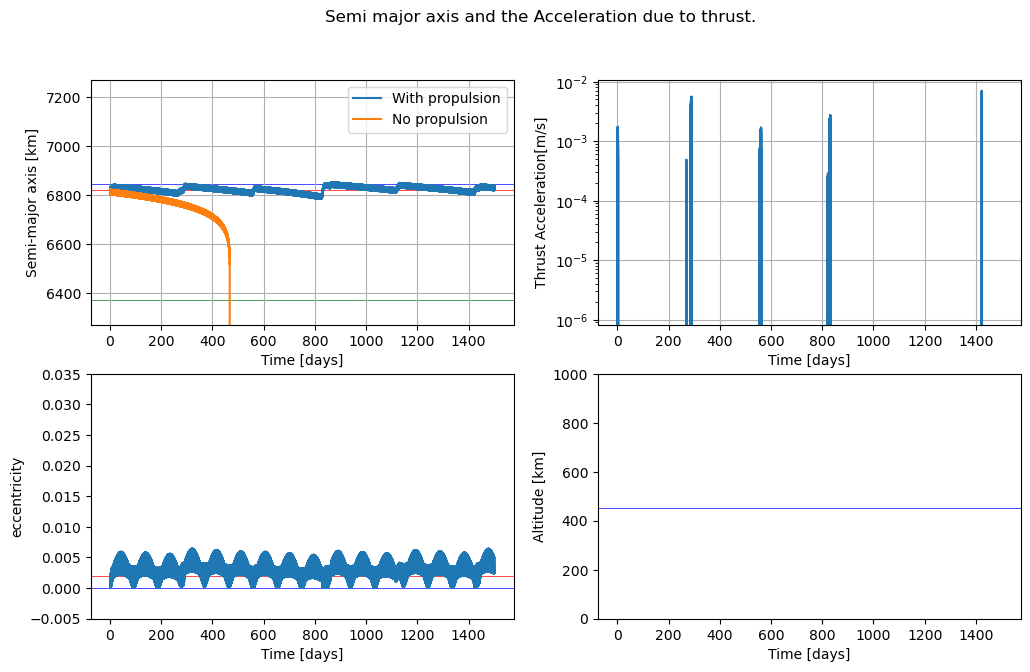

In [23]:
Time_0 = np.loadtxt('./Case0Timestep'+str(T_step)+'Altitude'+str(Altitude)+'time.txt', delimiter = ",")
Case_0 = np.loadtxt('./Case0Timestep'+str(T_step)+'Altitude'+str(Altitude)+'results.txt', delimiter = ",")
fig, (((ax1),(ax2)),((ax3),(ax4))) = plt.subplots(2, 2, figsize=(12, 7))
#fig, ((ax1)) = plt.subplots(1, 1, figsize=(20, 10))
fig.suptitle('Semi major axis and the Acceleration due to thrust.')

# Semi-major Axis
semi_major_axis = kepler_elements[:,0] / 1e3
ax1.plot(Time_1, Case_1, label = 'With propulsion')
ax1.plot(Time_0, Case_0, label = 'No propulsion')
#ax1.plot(Time_1, (r_earth+Altitude_plot)/1000)
ax1.axhline(y= (r_earth+Altitude)/1000, xmin=0,xmax=1,c="red",linewidth=0.5,zorder=0)
ax1.axhline(y= (r_earth+Altitude*1.05)/1000, xmin=0,xmax=1,c="blue",linewidth=0.5,zorder=0)
ax1.axhline(y= (r_earth)/1000, xmin=0,xmax=1,c="green",linewidth=0.5,zorder=0)
ax1.set_ylim([r_earth/1000-100, (r_earth+2*Altitude)/1000])
ax1.set_ylabel('Semi-major axis [km]')
ax1.set_xlabel('Time [days]')
ax1.grid( linestyle='-')

ax1.legend()

Thrust_plot = dep_vars_array[:,15]
ax2.plot(Time_1, Thrust_plot)#ax2.plot(Time_1[::100], Thrust_plot[::100])
ax2.set_yscale('log')
ax2.set_ylabel('Thrust Acceleration[m/s]')
ax2.set_xlabel('Time [days]')
ax2.grid( linestyle='-')
#ax2.set_xlim(0.03,0.04)

ax3.plot(Time_1, dep_vars_array[:,5])
ax3.set_ylabel('eccentricity')
ax3.set_xlabel('Time [days]')
ax3.axhline(y= 0, xmin=0,xmax=1,c="blue",linewidth=0.5,zorder=0)
ax3.axhline(y= 0.002, xmin=0,xmax=1,c="red",linewidth=0.5,zorder=0)
ax3.set_ylim(-0.005,.035)


ax4.plot(Time_1, Altitude_plot)
ax4.set_ylabel('Altitude [km]')
ax4.set_xlabel('Time [days]')
ax4.axhline(y= Altitude/1000, xmin=0,xmax=1,c="blue",linewidth=0.5,zorder=0)
ax4.set_ylim(0,1000)

fig.savefig( fname = 'Case1Propellant'+str(Propellant_id)+'Altitude'+str(Altitude)+' max time '+str(maxdays)+'results.pdf', bbox_inches='tight')

In [16]:
# from mpl_toolkits import mplot3d
# fig = plt.figure()
# ax = plt.axes(projection='3d')

# ax.plot(dep_vars_array[:,12], dep_vars_array[:,13], dep_vars_array[:,14], label = 'No propulsion')
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')

# fig, ((ax1)) = plt.subplots(1, 1, figsize=(10, 5))
# fig.suptitle('velocity-laser angle')

# # Semi-major Axis
# ax1.scatter(timeforthis[0:10000], Laser_velocity_angle_array[0:10000], label = '-')
# ax1.set_ylabel('Laser-velocity angle [degrees]')
# ax1.set_xlabel('Time [days]')
# fig.savefig( fname = 'Vel-laser-angle.pdf', bbox_inches='tight')

In [17]:
#massflow
#elevation isnt enough
#velocity angle 90+
#global variables
#extract non depvar variables how?